## Data Analysis using BulkLMM - BXD Spleen Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using BenchmarkTools

In [2]:
using Plots

In [3]:
local_path = "../../BulkLMM.jl/src";

In [4]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));

In [5]:
include(joinpath(local_path, "../test/testHelpers.jl"));

### Load data:

In [6]:
bulklmmdir = local_path;
pheno_file = joinpath(bulklmmdir,"..","data/bxdData/spleen-pheno-nomissing.csv");
pheno = readdlm(pheno_file, ',', header = false);
pheno_processed = pheno[2:end, 2:(end-1)].*1.0; # exclude the header, the first (transcript ID)and the last columns (sex)

In [7]:
geno_file = joinpath(bulklmmdir,"..","data/bxdData/spleen-bxd-genoprob.csv");
geno = readdlm(geno_file, ',', header = false);
geno_processed = geno[2:end, 1:2:end] .* 1.0;

In [8]:
size(pheno_processed) # (number of strains, number of traits)

(79, 35554)

In [9]:
size(geno_processed) # (number of strains, number of traits)

(79, 7321)

In [10]:
@time kinship = calcKinship(geno_processed); # calculate K

  1.147009 seconds (30.81 k allocations: 862.019 MiB, 46.23% gc time)


### Single trait scans:

In [11]:
traitID = 1112;
pheno_y = reshape(pheno_processed[:, traitID], :, 1);

In [12]:
@time single_results = scan(pheno_y, geno_processed, kinship);

  1.042833 seconds (730.48 k allocations: 86.439 MiB, 15.96% gc time, 93.15% compilation time)


In [13]:
@time single_results_perms = scan(pheno_y, geno_processed, kinship; permutation_test = true, nperms = 1000, original = false);

  1.574728 seconds (1.94 M allocations: 190.971 MiB, 8.38% gc time, 87.15% compilation time)


In [14]:
thrs = get_thresholds(single_results_perms, [0.85, 0.95]).thrs

2-element Vector{Float64}:
 3.2561257676274438
 3.789897345438132

### Multiple trait scans:

In [15]:
Threads.nthreads()

16

In [16]:
BLAS.get_num_threads()

8

In [17]:
BLAS.set_num_threads(4)

In [18]:
h2_grid = collect(0.0:0.01:0.99);

In [19]:
h2_grid2 = collect(0.0:0.05:0.95);

In [20]:
pheno_st = colStandardize(pheno_processed);

In [21]:
@benchmark bulkscan_null_grid(pheno_processed, geno_processed, kinship, h2_grid)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 11.477 s (8.51% GC) to evaluate,
 with a memory estimate of 17.66 GiB, over 49213973 allocations.

In [22]:
@benchmark bulkscan_null_grid(pheno_processed, geno_processed, kinship, h2_grid2)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 5.257 s (3.60% GC) to evaluate,
 with a memory estimate of 6.79 GiB, over 10608597 allocations.

In [23]:
@time all_results_grid = bulkscan_null_grid(pheno_processed, geno_processed, kinship, h2_grid);

 12.448525 seconds (49.21 M allocations: 17.664 GiB, 13.91% gc time)


In [24]:
@time all_results_grid_st = bulkscan_null_grid(pheno_st, geno_processed, kinship, h2_grid;
                                               prior_variance = 1.0, prior_sample_size = 0.1);

 12.383009 seconds (49.06 M allocations: 17.617 GiB, 13.34% gc time)


In [25]:
@time all_results_exact = bulkscan_null(pheno_processed, geno_processed, kinship;
                                        optim_interval = 10);

216.740152 seconds (3.09 G allocations: 793.648 GiB, 29.10% gc time, 0.03% compilation time)


In [26]:
@time all_results_exact_st = bulkscan_null(pheno_st, geno_processed, kinship;
                                           prior_variance = 1.0, prior_sample_size = 0.1,
                                           optim_interval = 10);

217.155573 seconds (3.09 G allocations: 793.650 GiB, 30.00% gc time)


In [27]:
all_results_grid_st.L[:, 1]

7321-element Vector{Float64}:
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682099685866
 0.00012008682099685866
 0.00012008387637556666
 0.00011849771856266301
 0.009521311901905454
 ⋮
 0.2601784885542237
 0.260178515033613
 0.26017851503362266
 0.25344638801936414
 0.37828935830761523
 0.37828935830771454
 0.219351399915556
 0.20144120787678205
 0.20153298758762145
 0.17782339280605816
 0.1817067156392548
 0.18170671563924326

In [28]:
all_results_exact_st.L[:, 1]

7321-element Vector{Float64}:
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682101019057
 0.00012008682099685866
 0.00012008682099685866
 0.00012008387637556666
 0.00011849771856266301
 0.009521311901905454
 ⋮
 0.26017848855422565
 0.26017851503361494
 0.26017851503362655
 0.2534463880193661
 0.37828935830761523
 0.37828935830771454
 0.219351399915556
 0.2014412078767801
 0.20153298758761953
 0.17782339280605625
 0.1817067156392529
 0.18170671563924135

In [29]:
unique(all_results_grid_st.h2_null_list)

72-element Vector{Float64}:
 0.0
 0.77
 0.45
 0.38
 0.83
 0.61
 0.69
 0.51
 0.86
 0.5
 0.78
 0.63
 0.47
 ⋮
 0.31
 0.28
 0.34
 0.35
 0.39
 0.81
 0.33
 0.96
 0.85
 0.29
 0.3
 0.26

In [30]:
hcat(all_results_exact_st.h2_null_list, all_results_grid_st.h2_null_list)

35554×2 Matrix{Float64}:
 7.72967e-16  0.0
 8.5778e-16   0.0
 3.80061e-16  0.0
 2.55675e-16  0.0
 9.95012e-16  0.0
 6.14951e-16  0.0
 1.21706e-15  0.0
 1.60996e-15  0.0
 1.60996e-15  0.0
 2.55675e-16  0.0
 3.92906e-16  0.0
 1.37507e-15  0.0
 6.10399e-16  0.0
 ⋮            
 6.14951e-16  0.0
 4.67033e-16  0.0
 0.648527     0.65
 3.92906e-16  0.0
 2.55675e-16  0.0
 0.472558     0.47
 3.92906e-16  0.0
 5.7072e-16   0.0
 8.31578e-16  0.0
 0.678456     0.68
 9.95012e-16  0.0
 3.59999e-16  0.0

In [31]:
findmax(abs.(all_results_exact_st.h2_null_list .- all_results_grid_st.h2_null_list))

(0.005234142856513024, 31325)

In [32]:
all_results_exact_st.h2_null_list[31325], all_results_grid_st.h2_null_list[31325]

(0.955234142856513, 0.95)

In [33]:
findmax(abs.(all_results_exact_st.L .- all_results_grid_st.L))

(0.2072097903325414, CartesianIndex(376, 7885))

In [34]:
all_results_exact_st.h2_null_list[7885], all_results_grid_st.h2_null_list[7885]

(0.9443117628380906, 0.94)

In [35]:
BLAS.get_num_threads()

1

In [38]:
findall(all_results_exact.h2_null_list .> 0.99)

76-element Vector{Int64}:
  1634
  3403
  3745
  5754
  7412
  7508
  8062
  8075
  8082
  8227
  8361
  8612
  9762
     ⋮
 31845
 31861
 32032
 32062
 32346
 32386
 32655
 32773
 32783
 33456
 34151
 34342

In [46]:
U = eigen(kinship).vectors;

In [47]:
D = eigen(kinship).values;

In [52]:
D[1] = 0.0

0.0

In [53]:
kinship_Gc = U*diagm(D)*U';

In [81]:
spleen_id = findall(all_results_exact.h2_null_list .> 0.99)[4]

5754

Loglik plot: 


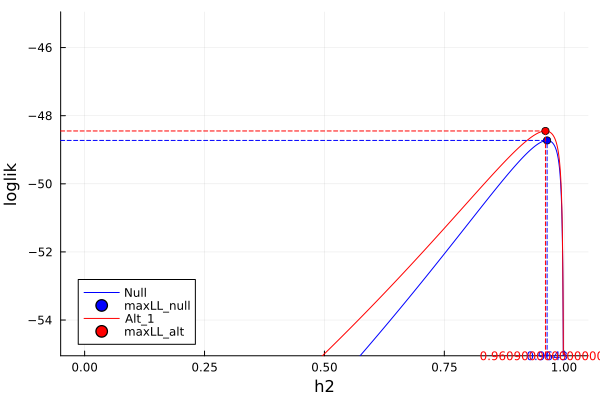

  0.325469 seconds (545.99 k allocations: 252.743 MiB)


In [97]:
@time test_single = scan(reshape(pheno_processed[:, spleen_id], :, 1), geno_processed, kinship;
                         prior_variance = 1.0, prior_sample_size = 0.1,
                         plot_loglik = true, markerID = 1, h2_grid = collect(0.0:9999).*0.0001,
                         x_lims = [0.0, 1.0], y_lims = [-55.0, -45.0]);

Loglik plot: 


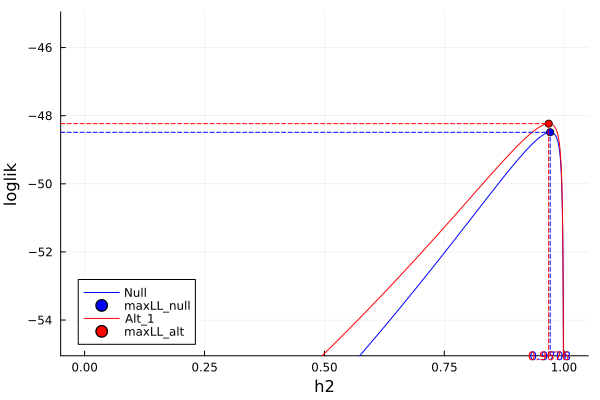

  0.996201 seconds (546.02 k allocations: 252.752 MiB, 63.36% gc time)


In [94]:
@time test_single_Gc = scan(reshape(pheno_processed[:, spleen_id], :, 1), geno_processed, kinship_Gc;
                            prior_variance = 1.0, prior_sample_size = 0.1,
                            plot_loglik = true, markerID = 1, h2_grid = collect(0.0:9999).*0.0001,
                            x_lims = [0.0, 1.0], y_lims = [-55.0, -45.0]);